In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import os
import matplotlib.pyplot as plt

In [ ]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
print("Path to dataset files:", path)

# Path variables
dataset_path = f"{path}/images/Images"

100%|██████████| 750M/750M [00:06<00:00, 130MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [ ]:
# Data preprocessing
image_size = 299  # Required input size for InceptionResNetV2
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% validation split for train and validation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True  # Shuffle data for training
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# For simplicity, we'll use the validation set as the test set in this example.
test_generator = val_generator

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
# Load the InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Batch size: {train_generator.batch_size}")
for batch, labels in train_generator:
    print(batch.shape, labels.shape)
    break

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training samples: 16508
Validation samples: 4072
Batch size: 32
(32, 299, 299, 3) (32, 120)


In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generator.class_indices)), dtype=tf.float32),
    )
).repeat()  # Ensures infinite looping of the dataset

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(val_generator.class_indices)), dtype=tf.float32),
    )
).repeat()

In [ ]:
# Train the model
train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size

print(f"Steps per epoch (training): {train_steps}")
print(f"Validation steps: {val_steps}")

Steps per epoch (training): 515
Validation steps: 127


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,  # Explicitly set the correct steps
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=10,
    verbose=1
)

# Fine-tuning: Unfreeze some layers in the base model and retrain
for layer in base_model.layers[:200]:
    layer.trainable = False
for layer in base_model.layers[200:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,  # Same steps as initial training
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=total_epochs,
    initial_epoch=10
)


Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 118s 166ms/step - accuracy: 0.0235 - loss: 4.7342 - val_accuracy: 0.1309 - val_loss: 4.4876
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.2012 - loss: 4.4013 - val_accuracy: 0.4871 - val_loss: 4.1560
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 55s 108ms/step - accuracy: 0.5771 - loss: 4.0637 - val_accuracy: 0.7557 - val_loss: 3.8087
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 55s 106ms/step - accuracy: 0.7782 - loss: 3.7169 - val_accuracy: 0.8290 - val_loss: 3.4458
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - accuracy: 0.8416 - loss: 3.3465 - val_accuracy: 0.8601 - val_loss: 3.0621
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.8660 - loss: 2.9637 - val_accuracy: 0.8733 - val_loss: 2.6834
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.8762 - loss: 2.5888 - val_accuracy: 0.8842 - val_loss: 2.3066
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.8873 - loss: 2.

In [ ]:
# print(history.history['accuracy'])

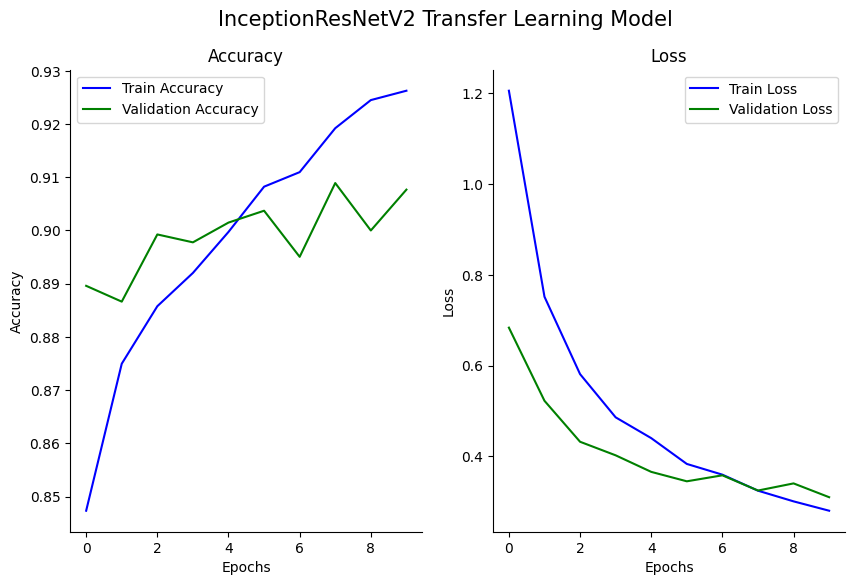

In [ ]:
acc        = history_fine_tune.history['accuracy']
val_acc    = history_fine_tune.history['val_accuracy']
loss       = history_fine_tune.history['loss']
val_loss   = history_fine_tune.history['val_loss']
num_epochs = range(len(acc))

# Plot the Training and Test accuracy over all the epochs
fig1, ax1 = plt.subplots(1, 2, figsize = (10, 6))
fig1.suptitle('InceptionResNetV2 Transfer Learning Model', c = 'k', fontsize = '15')

ax1[0].plot(acc, 'b-', label = 'Train Accuracy')
ax1[0].plot(val_acc, 'g-', label = 'Validation Accuracy')
ax1[0].set_title('Accuracy')
ax1[0].legend()
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Accuracy')
ax1[0].spines['right'].set_visible(False)
ax1[0].spines['top'].set_visible(False)

ax1[1].plot(loss, 'b-', label = 'Train Loss')
ax1[1].plot(val_loss, 'g-', label = 'Validation Loss')
ax1[1].set_title('Loss')
ax1[1].legend()
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].spines['right'].set_visible(False)
ax1[1].spines['top'].set_visible(False)

In [ ]:
# # Evaluate the model on validation data
# loss, accuracy = model.evaluate(val_generator, steps=val_steps)
# print(f"Validation Accuracy: {accuracy:.2f}")

# # Plot training and validation accuracy
# plt.figure()
# plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.show()

In [ ]:
model.save('breed_model.keras')
#model.save_weights('breed_model_weights.weights.h5')

In [ ]:
print("Standalone Keras Version:", tf.keras.__version__)
print("TensorFlow Keras Version:", tf.keras.__version__)
print("TensorFlow Version:", tf.__version__)

Standalone Keras Version: 3.5.0
TensorFlow Keras Version: 3.5.0
TensorFlow Version: 2.17.1


In [ ]:
breed_classes = sorted(
    [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))],
    key=lambda d: os.path.getmtime(os.path.join(dataset_path, d)),
    reverse=True  # Set to True for most recently modified first
)

# Print the class names sorted by modification date
breed_classes.reverse()
print(breed_classes)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t